# ChemEmbed v0.1 on HerbalDB+COCONUT_DB dataset
by gbyuvd | CC-BY-SA-3.0

Contents:
- Part I: Importing and Loading Model
- Part II: Preparing the Dataset and its FAISS-Index
(You can skip Part II if the index is available/already done)
- Part III: Querying One Molecule as Input
- Part IV: Querying Multiple Molecule and using Averaged Embedding

## I Importing Libraries and Loading Model
Be sure to use GPU/CUDA for faster embedding and search; though this tutorial uses faiss-cpu, if you can please install faiss-gpu via Conda-forge.

In [1]:
# imports
from sentence_transformers import SentenceTransformer
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm.notebook import tqdm
import selfies as sf
from rdkit.Chem import Draw
import numpy as np
from sklearn.preprocessing import normalize
import faiss
from rdkit.Chem import Draw, Descriptors
from IPython.display import display
import matplotlib.pyplot as plt
import io
import pickle

tqdm.pandas()

In [3]:
# Load a model
model = SentenceTransformer('gbyuvd/ChemEmbed-v01')

In [4]:
# Test the encoding
test_input = "[C][=C][C][=C][C][=C][Ring1][=Branch1]"

print(model.encode(test_input))

[-5.96313715e-01 -3.53883207e-01  7.77864218e-01 -5.23557007e-01
 -4.52737540e-01  6.77953482e-01 -4.15824533e-01 -5.70002675e-01
  1.63262582e+00  3.55069131e-01  2.45583758e-01  6.97692156e-01
 -4.72451657e-01  3.51209700e-01  2.87253857e-01  9.09358382e-01
 -7.87061214e-01 -3.57809216e-01  5.65093935e-01  1.29190162e-01
 -5.90843149e-02  1.98276952e-01 -6.42475903e-01  1.13910306e+00
  1.38049698e+00  6.70257568e-01  8.46269056e-02  6.58876240e-01
 -6.37300968e-01 -6.98618114e-01 -6.88519359e-01  5.64441122e-02
 -1.08984935e+00 -2.23714650e-01  2.41019264e-01 -5.51084988e-03
 -1.54954955e-01  1.83547866e-02  4.11094427e-01  7.33052969e-01
 -2.01292913e-02 -3.79723340e-01  4.49139297e-01  2.04939795e+00
 -6.20818079e-01 -2.36807644e-01  6.93232536e-01 -5.09365052e-02
  5.36189139e-01  4.99942660e-01  7.25762129e-01  3.35252404e-01
 -8.59136701e-01  9.57611427e-02 -3.78511488e-01 -5.28418362e-01
 -2.35421062e-01 -2.92907178e-01  5.34086406e-01  1.21565700e+00
 -8.05543736e-02  6.35722

## II Preparing the Dataset and FAISS-Index
(Skip to Part III if Already Done)

### II.1 Combining HerbalDB and COCONUTDB

In [ ]:
natprod = pd.read_csv("./db_raw/COCONUT_DB.smi", header=None, sep='\s+')
natprod.drop_duplicates()

In [ ]:
natprod = natprod.rename(columns=({0 : 'CSMI', 1: 'Name'}))

### II.2 Generate SELFIES of each CSMI

In [ ]:
def mw_calc(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        return Descriptors.MolWt(mol)
    else:
        return None  # Return None for invalid SMILES

# Apply the function to calculate MW and filter out invalid rows
natprod['MW'] = natprod['CSMI'].progress_apply(mw_calc)

# Remove rows where MW is None (invalid SMILES)
natprod = natprod.dropna(subset=['MW'])

print(natprod.head(5))


In [ ]:
def smiles_to_selfies(smiles):
    try:
        return sf.encoder(smiles)
    except sf.EncoderError:
        return None  # Return None if encoding fails

def selfies_to_smiles(selfies):
    try:
        return sf.decoder(selfies)
    except sf.DecoderError:
        return None  # Return None if decoding fails

# Convert SMILES to SELFIES
natprod['SELFIES'] = natprod['CSMI'].progress_apply(smiles_to_selfies)

# Remove rows where SELFIES conversion resulted in None
natprod = natprod[natprod['SELFIES'].notnull()]

In [ ]:
print(len(natprod))
natprod.head(5)

In [ ]:
sorted_natprod = natprod.sort_values(by='MW', ascending=True)
sorted_natprod.head(10)

In [ ]:
sorted_natprod.to_parquet("./natprob_mw.parquet", engine='pyarrow', compression='snappy')

### II.3 Generating Embeddings and FAISS Index

In [6]:
df = pd.read_parquet("natprob_mw.parquet", engine='pyarrow')

def generate_embed(selfies):
    embeddings = model.encode(selfies)
    return embeddings

df['embeddings'] = df['SELFIES'].progress_apply(lambda x: generate_embed(x))

  0%|          | 0/406913 [00:00<?, ?it/s]

In [7]:
# Normalize embeddings
embeddings = normalize(df['embeddings'].tolist())

embeddings_array = np.array(embeddings, dtype=np.float32)
dimension = embeddings_array.shape[1]


In [8]:
# Cosine sim
index = faiss.IndexFlatIP(dimension)
index.add(embeddings_array)

In [ ]:
# Eucledian distance
# index = faiss.IndexFlatL2(dimension)
# index.add(embeddings_array)

In [9]:
# metadata
metadata = df[['CSMI', 'Name', 'MW']].to_dict(orient='records')

faiss.write_index(index, 'faiss_index-cos.idx')

import pickle

with open('metadata-cos.pkl', 'wb') as f:
    pickle.dump(metadata, f)

## III Query One Molecule


Query Molecule:


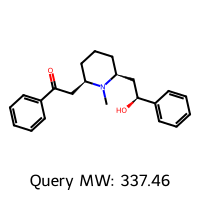


Search Results:


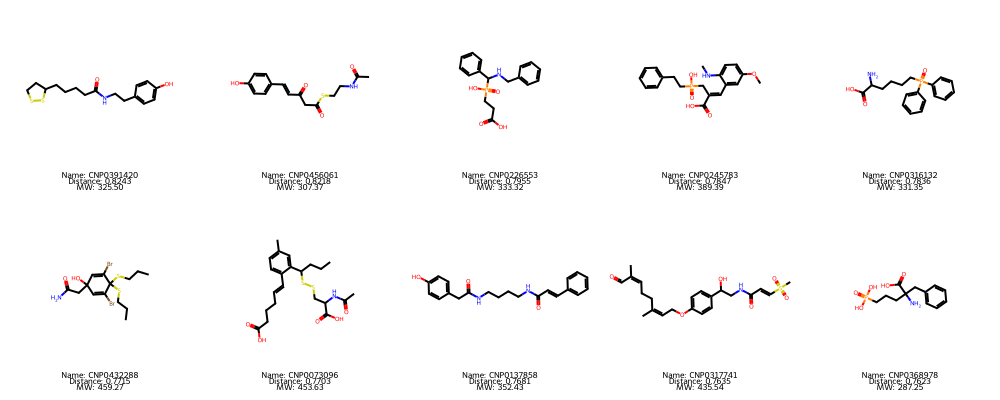


Detailed Results:
{'Distance': np.float32(0.8243457), 'CSMI': 'O=C(NCCC1=CC=C(O)C=C1)CCCCC2SSCC2', 'Name': 'CNP0391420', 'MW': 325.499}
{'Distance': np.float32(0.8217527), 'CSMI': 'O=C(SCCNC(=O)C)CC(=O)C=CC1=CC=C(O)C=C1', 'Name': 'CNP0456061', 'MW': 307.37100000000004}
{'Distance': np.float32(0.7955498), 'CSMI': 'O=C(O)CCP(=O)(O)C(NCC=1C=CC=CC1)C=2C=CC=CC2', 'Name': 'CNP0226553', 'MW': 333.32400000000007}
{'Distance': np.float32(0.78466785), 'CSMI': 'O=C(O)C(=CC1=CC(OC)=CC=C1NC)CP(=O)(O)CCC=2C=CC=CC2', 'Name': 'CNP0245783', 'MW': 389.38800000000015}
{'Distance': np.float32(0.7835964), 'CSMI': 'O=C(O)C(N)CCCCP(=O)(C=1C=CC=CC1)C=2C=CC=CC2', 'Name': 'CNP0316132', 'MW': 331.35200000000003}
{'Distance': np.float32(0.771526), 'CSMI': 'O=C(N)CC1(O)C=C(Br)C(SCCC)(SCCC)C(Br)=C1', 'Name': 'CNP0432288', 'MW': 459.2690000000002}
{'Distance': np.float32(0.7703235), 'CSMI': 'O=C(O)CCCC=CC1=CC=C(C=C1C(SSCC(NC(=O)C)C(=O)O)CCC)C', 'Name': 'CNP0073096', 'MW': 453.6260000000003}
{'Distance': np.float32(

In [15]:
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Chem.MolToSmiles(mol, isomericSmiles=True)

def to_selfies(smi):
    try:
        selfies = sf.encoder(smi)
        return selfies
    except sf.EncoderError:
        pass

def to_smiles(slf):
    try:
        smiles = sf.decoder(slf)
        return smiles
    except sf.DecoderError:
        pass

# Load the FAISS index and metadata
index = faiss.read_index('faiss_index-cos.idx')
with open('metadata-cos.pkl', 'rb') as f:
    metadata = pickle.load(f)

# Function to generate embeddings for a given SELFIES string
def generate_embedding_for_query(model, selfies):
    embedding = model.encode([selfies])
    return embedding

# Given a SELFIES string, generate its embedding
query_smiles = standardize_smiles("CN1[C@@H](CCC[C@@H]1CC(=O)C2=CC=CC=C2)C[C@@H](C3=CC=CC=C3)O") # Lobeline
query_selfies = to_selfies(query_smiles)
query_embedding = generate_embedding_for_query(model, query_selfies)

# Normalize the query embedding (if the embeddings were normalized)
query_embedding = normalize(query_embedding)

# Search the FAISS index for the 10 most similar entries
k = 10  # Number of nearest neighbors to retrieve
D, I = index.search(np.array(query_embedding, dtype=np.float32), k)

# Retrieve metadata for the nearest neighbors
nearest_meta = [metadata[i] for i in I[0]]

# Prepare the results
results = []
for dist, meta in zip(D[0], nearest_meta):
    result = {
        'Distance': dist,
        'CSMI': meta['CSMI'],
        'Name': meta['Name'],
        'MW': meta['MW']
    }
    results.append(result)

# Function to visualize the SMILES with their MW
def visualize_smiles_with_legend(smiles, legend):
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolsToImage([mol], subImgSize=(200, 200), legends=[legend])
    return img

# Visualize the query molecule with its MW
query_mol = Chem.MolFromSmiles(query_smiles)
query_mw = Descriptors.MolWt(query_mol)
query_legend = f'Query MW: {query_mw:.2f}'
query_img = visualize_smiles_with_legend(query_smiles, query_legend)

print("\nQuery Molecule:")
# Display the query molecule image
display(query_img)

# Visualize the results molecules with their name, distance, and MW
results_smiles = [meta['CSMI'] for meta in nearest_meta]
results_legends = [f'Name: {meta["Name"]}\nDistance: {dist:.4f}\nMW: {meta["MW"]:.2f}' for dist, meta in zip(D[0], nearest_meta)]
results_img = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in results_smiles], molsPerRow=5, subImgSize=(200, 200), legends=results_legends)

print("\nSearch Results:")
# Display the results images
display(results_img)

print("\nDetailed Results:")
# Display the results in text form
for result in results:
    print(result)


In [8]:
print(results)

[{'Distance': np.float32(0.8243457), 'CSMI': 'O=C(NCCC1=CC=C(O)C=C1)CCCCC2SSCC2', 'Name': 'CNP0391420', 'MW': 325.499}, {'Distance': np.float32(0.8217527), 'CSMI': 'O=C(SCCNC(=O)C)CC(=O)C=CC1=CC=C(O)C=C1', 'Name': 'CNP0456061', 'MW': 307.37100000000004}, {'Distance': np.float32(0.7955498), 'CSMI': 'O=C(O)CCP(=O)(O)C(NCC=1C=CC=CC1)C=2C=CC=CC2', 'Name': 'CNP0226553', 'MW': 333.32400000000007}, {'Distance': np.float32(0.78466785), 'CSMI': 'O=C(O)C(=CC1=CC(OC)=CC=C1NC)CP(=O)(O)CCC=2C=CC=CC2', 'Name': 'CNP0245783', 'MW': 389.38800000000015}, {'Distance': np.float32(0.7835964), 'CSMI': 'O=C(O)C(N)CCCCP(=O)(C=1C=CC=CC1)C=2C=CC=CC2', 'Name': 'CNP0316132', 'MW': 331.35200000000003}, {'Distance': np.float32(0.771526), 'CSMI': 'O=C(N)CC1(O)C=C(Br)C(SCCC)(SCCC)C(Br)=C1', 'Name': 'CNP0432288', 'MW': 459.2690000000002}, {'Distance': np.float32(0.7703235), 'CSMI': 'O=C(O)CCCC=CC1=CC=C(C=C1C(SSCC(NC(=O)C)C(=O)O)CCC)C', 'Name': 'CNP0073096', 'MW': 453.6260000000003}, {'Distance': np.float32(0.76812965)

## IV Query Multiple Molecule

In [18]:
# Example list of SMILES strings
# For example: Cystisine, Varenicline, Lobeline
smiles_list = [
    "C1[C@H]2CNC[C@@H]1C3=CC=CC(=O)N3C2",
    "C1[C@@H]2CNC[C@H]1C3=CC4=NC=CN=C4C=C23",
    "CN1[C@@H](CCC[C@@H]1CC(=O)C2=CC=CC=C2)C[C@@H](C3=CC=CC=C3)O",
]

# Function to convert SMILES to SELFIES
def smiles_to_selfies(smiles):
    return sf.encoder(smiles)

# Standardize the SMILES
stdsmiles_list = [standardize_smiles(smiles) for smiles in smiles_list]

# Convert SMILES to SELFIES
selfies_list = [smiles_to_selfies(smiles) for smiles in stdsmiles_list]

# Function to generate embeddings for a given SELFIES string
def generate_embedding_for_selfies(model, selfies):
    embedding = model.encode([selfies])
    return embedding

# Generate embeddings for each SELFIES
embeddings = [generate_embedding_for_selfies(model, selfies) for selfies in selfies_list]

# Convert list of embeddings to a numpy array
embeddings_array = np.vstack(embeddings)

# Normalize the embeddings if required
embeddings_array = normalize(embeddings_array)

# Average the embeddings
average_embedding = np.mean(embeddings_array, axis=0)


Query Molecules:


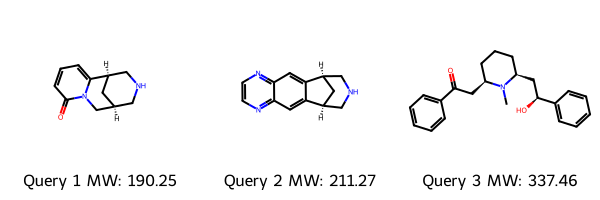


Search Results:


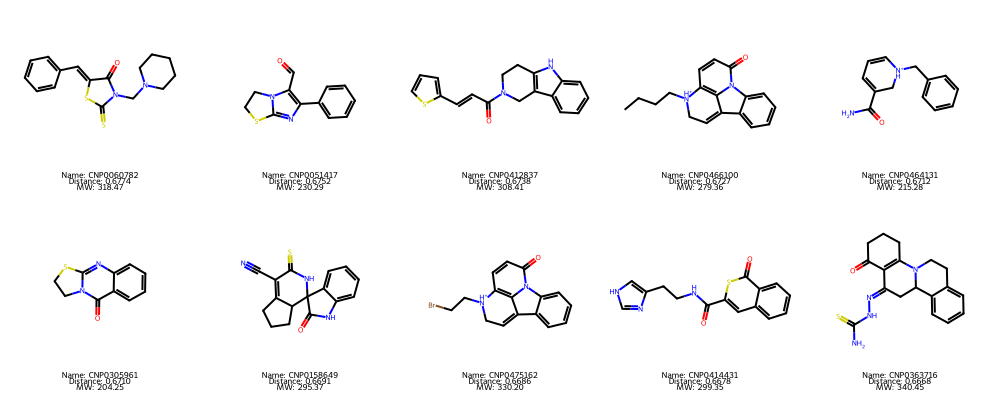


Detailed Results:
1. {'Distance': np.float32(0.67744416), 'CSMI': 'O=C1C(SC(=S)N1CN2CCCCC2)=CC=3C=CC=CC3', 'Name': 'CNP0060782', 'MW': 318.4669999999999}
2. {'Distance': np.float32(0.6751733), 'CSMI': 'O=CC1=C(N=C2SCCN21)C=3C=CC=CC3', 'Name': 'CNP0051417', 'MW': 230.29200000000003}
3. {'Distance': np.float32(0.67378664), 'CSMI': 'O=C(C=CC=1SC=CC1)N2CC=3C=4C=CC=CC4NC3CC2', 'Name': 'CNP0412837', 'MW': 308.40600000000006}
4. {'Distance': np.float32(0.6727268), 'CSMI': 'O=C1C=CC2=C3C(=CC[NH+]2CCCC)C=4C=CC=CC4N13', 'Name': 'CNP0466100', 'MW': 279.363}
5. {'Distance': np.float32(0.671174), 'CSMI': 'O=C(N)C1=CC=C[NH+](CC=2C=CC=CC2)C1', 'Name': 'CNP0464131', 'MW': 215.27599999999998}
6. {'Distance': np.float32(0.670962), 'CSMI': 'O=C1C=2C=CC=CC2N=C3SCCN31', 'Name': 'CNP0305961', 'MW': 204.25399999999996}
7. {'Distance': np.float32(0.66914827), 'CSMI': 'N#CC=1C(=S)NC2(C(=O)NC=3C=CC=CC32)C4C1CCC4', 'Name': 'CNP0158649', 'MW': 295.36700000000013}
8. {'Distance': np.float32(0.66864073), 'CSMI': '

In [19]:
# Load the FAISS index and metadata
# index = faiss.read_index('faiss_index-cos.idx')
# with open('metadata-cos.pkl', 'rb') as f:
#     metadata = pickle.load(f)

# Search the FAISS index for the 10 most similar entries
k = 10  # Number of nearest neighbors to retrieve
D, I = index.search(np.array([average_embedding], dtype=np.float32), k)

# Retrieve metadata for the nearest neighbors
nearest_meta = [metadata[i] for i in I[0]]

# Prepare the results
results = []
for dist, meta in zip(D[0], nearest_meta):
    result = {
        'Distance': dist,
        'CSMI': meta['CSMI'],
        'Name': meta['Name'],
        'MW': meta['MW']
    }
    results.append(result)


# Function to visualize the SMILES with their MW
def visualize_smiles_with_legend(smiles, legend):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    img = Draw.MolsToImage([mol], subImgSize=(200, 200), legends=[legend])
    return img

# Visualize all query molecules
print("Query Molecules:")
query_imgs = []
for i, query_smiles in enumerate(stdsmiles_list):
    query_mol = Chem.MolFromSmiles(query_smiles)
    if query_mol is not None:
        query_mw = Descriptors.MolWt(query_mol)
        query_legend = f'Query {i+1} MW: {query_mw:.2f}'
        query_img = visualize_smiles_with_legend(query_smiles, query_legend)
        if query_img is not None:
            query_imgs.append((query_mol, query_legend))

# Display query molecules as a grid
if query_imgs:
    query_mols = [mol for mol, legend in query_imgs]
    query_legends = [legend for mol, legend in query_imgs]
    query_grid = Draw.MolsToGridImage(query_mols, molsPerRow=3, subImgSize=(200, 200), legends=query_legends)
    display(query_grid)

print("\nSearch Results:")
# Visualize the results molecules with their name, distance, and MW
results_mols = []
results_legends = []

for dist, meta in zip(D[0], nearest_meta):
    mol = Chem.MolFromSmiles(meta['CSMI'])
    if mol is not None:
        # Calculate MW if not in metadata
        if 'MW' in meta:
            mw = meta['MW']
        else:
            mw = Descriptors.MolWt(mol)
        
        legend = f'Name: {meta["Name"]}\nDistance: {dist:.4f}\nMW: {mw:.2f}'
        results_mols.append(mol)
        results_legends.append(legend)

# Display the results images
if results_mols:
    results_img = Draw.MolsToGridImage(results_mols, molsPerRow=5, subImgSize=(200, 200), legends=results_legends)
    display(results_img)

# Display the results in text form
print("\nDetailed Results:")
for i, result in enumerate(results):
    print(f"{i+1}. {result}")